In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# allows all columns to be seen rather than fit to display area
pd.set_option('display.max_columns', 500)

# DATA_PATH = "data/uk-2016-road-safety-data/"
# files = !ls $DATA_PATH
# pd.read_excel(DATA_PATH + files.grep("xls").s, sheet_name=1, header=2)

### Basic level

**Read the main dataset using Pandas.**

In [2]:
# accidents_2016 = pd.read_csv('./data/uk-2016-road-safety-data/dftRoadSafety_Accidents_2016.csv')

**Check the number of rows and columns.**

In [3]:
# accidents_2016.shape

**Check the data type of each column.**

In [4]:
# accidents_2016.dtypes

**Read the main dataset again, using `dtype={...}` argument to specify data types. See if you can avoid a mixed types warning.**

In [5]:
accidents_2016 = pd.read_csv("./data/uk-2016-road-safety-data/dftRoadSafety_Accidents_2016.csv", 
                             dtype={'LSOA_of_Accident_Location': object})

**Read the main dataset again, using an appropriate argument to specify missing data values.**

In [6]:
accidents_2016.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                             7
Location_Northing_OSGR                            7
Longitude                                         7
Latitude                                          7
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                              2
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                      37
Junction_Detail                                   0
Junction_Con

**Convert `Date` column to datetime.**

In [7]:
accidents_2016['Date'] = pd.to_datetime(accidents_2016['Date'], cache=True)

**Create a new column that shows month of a year value for every accident in the main dataset.**

In [8]:
accidents_2016.insert(loc=10, column='Month_of_Year_Int', value=accidents_2016['Date'].dt.month)
accidents_2016.insert(loc=11, column='Month_of_Year_Name', value=accidents_2016['Date'].dt.month_name())

**Create a new column that shows hour of the day (24h format) for every accident in the main dataset.**

In [9]:
accidents_2016.insert(loc=13, column='Hour_of_Day', value=pd.to_datetime(accidents_2016['Time'], cache=True).dt.hour)

**Report average number of casualties depending on accident severity.**

In [10]:
accidents_2016.groupby('Accident_Severity')['Number_of_Casualties'].mean()

Accident_Severity
1    1.775811
2    1.401749
3    1.306711
Name: Number_of_Casualties, dtype: float64

**Create a stacked barplot by accident severity occurrences in different months.** 

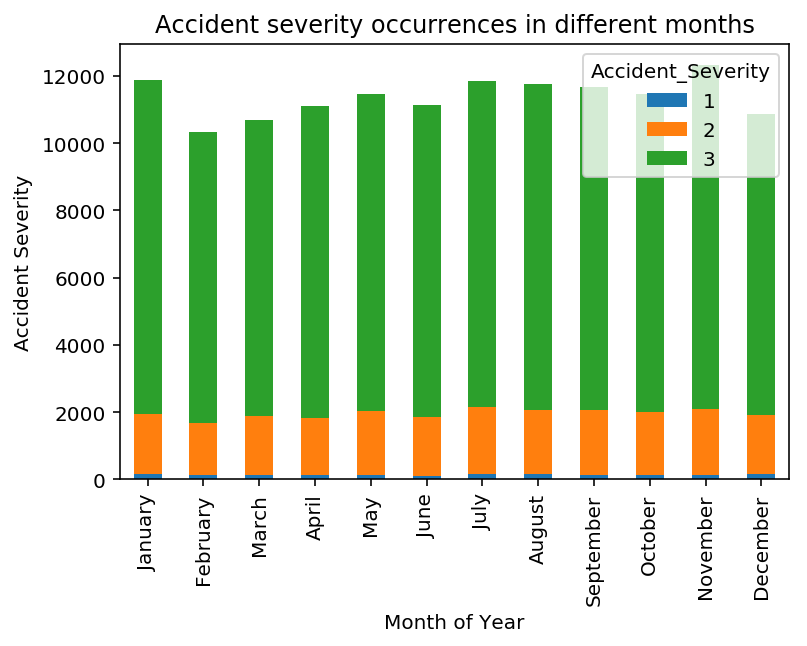

In [11]:
accidents_2016.groupby('Month_of_Year_Name', sort=False)\
    ['Accident_Severity'].value_counts().unstack().plot(kind="bar", stacked=True)

plt.xlabel("Month of Year");
plt.ylabel("Accident Severity");
plt.title("Accident severity occurrences in different months");

**Create a stacked barplot by accident severity occurrences in different months for the last full year of data only.** 

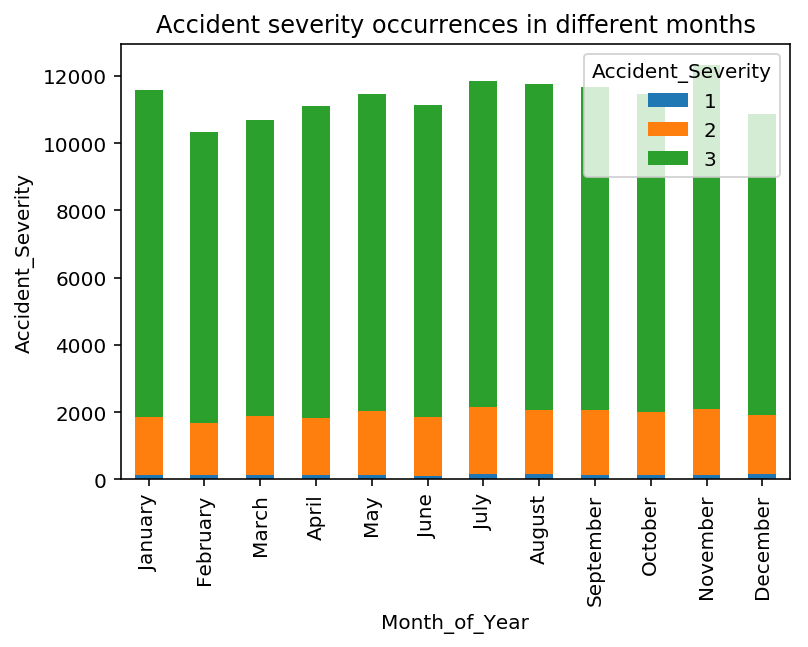

In [12]:
full_year_mask = accidents_2016[
                    (accidents_2016['Date'] > "2016-01-01") & 
                    (accidents_2016['Date'] <= "2016-12-31")]

full_year_mask.groupby('Month_of_Year_Name', sort=False)\
    ['Accident_Severity'].value_counts().unstack().plot(kind="bar", stacked=True)
plt.xlabel('Month_of_Year');
plt.ylabel('Accident_Severity');
plt.title('Accident severity occurrences in different months');

**Create a stacked barplot by accident severity occurrences based on the hour of the day.** 

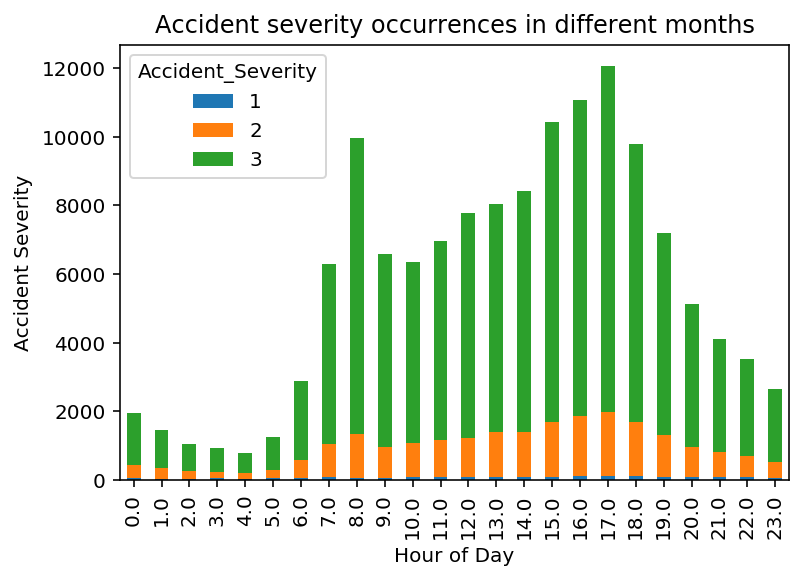

In [13]:
accidents_2016.groupby('Hour_of_Day')['Accident_Severity'].value_counts().unstack().plot(kind="bar", stacked=True)

plt.xlabel("Hour of Day");
plt.ylabel("Accident Severity");
plt.title("Accident severity occurrences in different months");

### Intermediate level

**Use appropriate plots for the following relationships:**
- Number of casualties by weather conditions
- Number of casualties by number of vehicles involved
- Number of casualties by hour of the day
- Number of casualties by month

In [14]:
data_guide_map = pd.read_excel("./data/uk-2016-road-safety-data/Road-Accident-Safety-Data-Guide.xls", sheet_name=None)

weather_dict = data_guide_map['Weather'].set_index('code').T.to_dict('list')

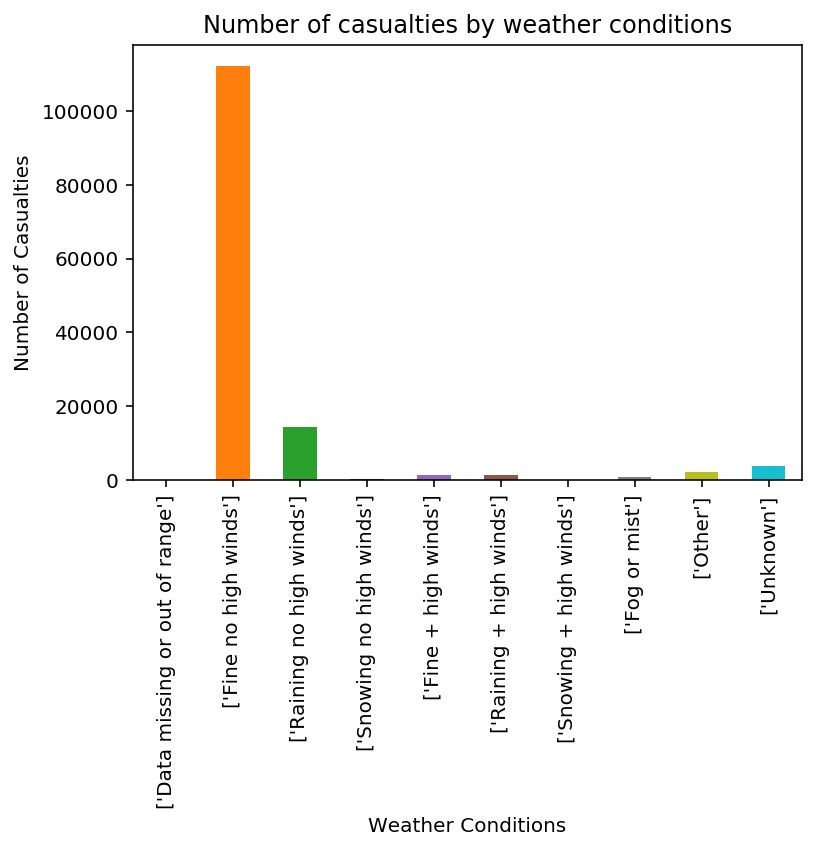

In [15]:
casualties_by_weather = accidents_2016.groupby('Weather_Conditions')['Number_of_Casualties'].count()
ax = casualties_by_weather.plot(kind="bar")

x_labels = [weather_dict[x] for x in casualties_by_weather.index]
ax.set_xticklabels(x_labels, rotation=90)

plt.xlabel("Weather Conditions");
plt.ylabel("Number of Casualties");
plt.title("Number of casualties by weather conditions");

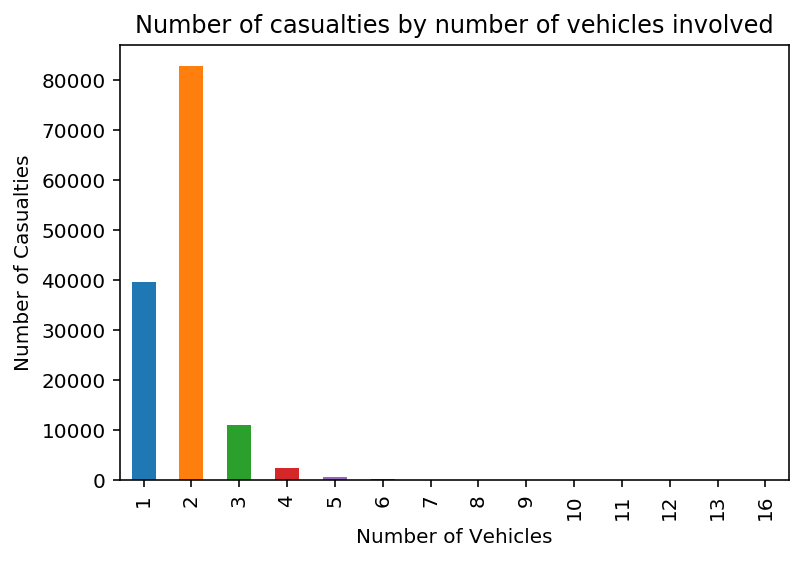

In [16]:
casualties_by_vehicles = accidents_2016.groupby('Number_of_Vehicles')['Number_of_Casualties'].count()
casualties_by_vehicles.plot(kind="bar")

plt.xlabel("Number of Vehicles");
plt.ylabel("Number of Casualties");
plt.title("Number of casualties by number of vehicles involved");

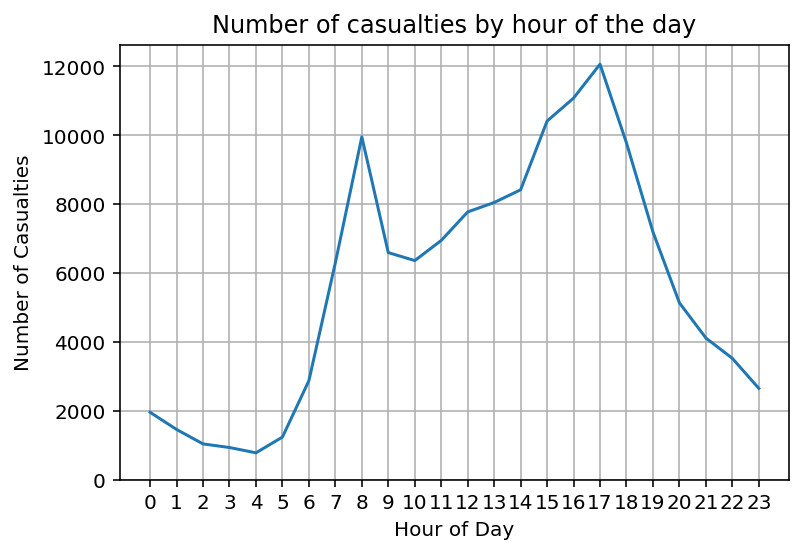

In [17]:
casualties_by_hour = accidents_2016.groupby('Hour_of_Day')['Number_of_Casualties'].count()
casualties_by_hour.plot(kind="line", grid=True, xticks=range(0,24), ylim=0)

plt.xlabel("Hour of Day");
plt.ylabel("Number of Casualties");
plt.title("Number of casualties by hour of the day");

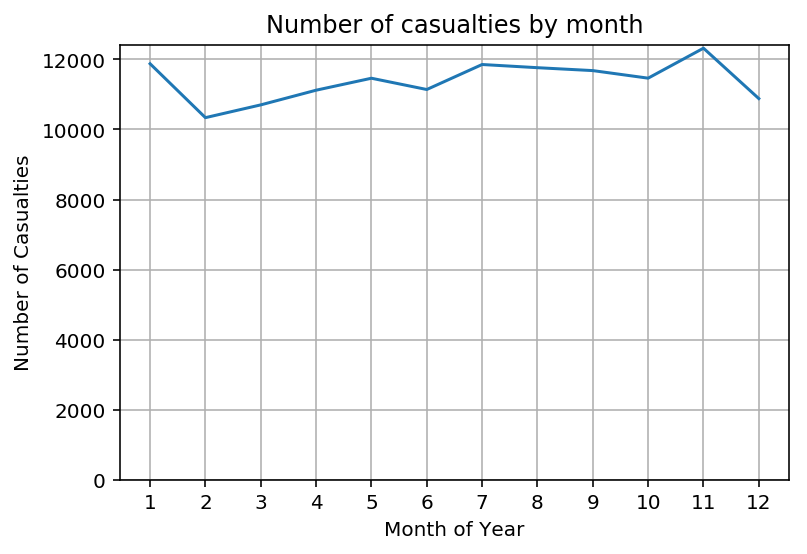

In [18]:
casualties_by_month = accidents_2016.groupby('Month_of_Year_Int')['Number_of_Casualties'].count()
casualties_by_month.plot(kind="line", grid=True, xticks=range(1,13), ylim=0)

plt.xlabel("Month of Year");
plt.ylabel("Number of Casualties");
plt.title("Number of casualties by month");

**Describe a nature of relationship between speed limit and accident severity.**

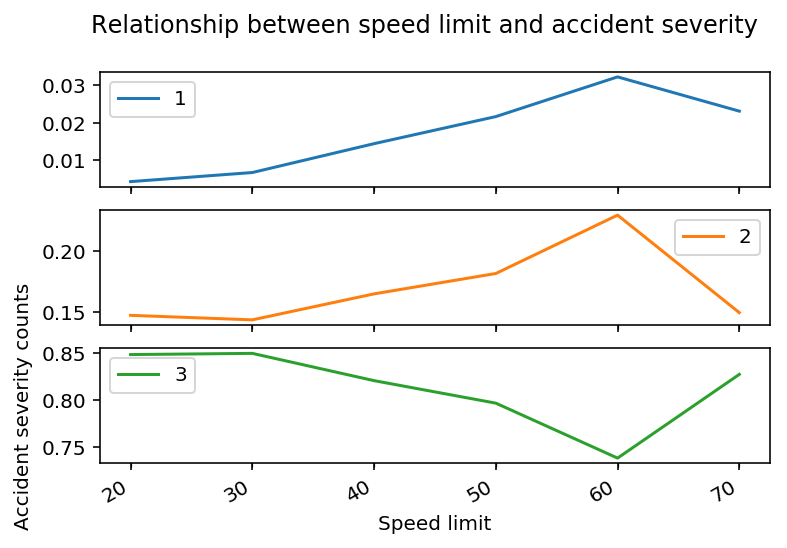

In [82]:
Speed_Severity = accidents_2016.groupby('Speed_limit')['Accident_Severity'].value_counts(normalize=True).unstack()
Speed_Severity.plot(kind="line", subplots=True, title="Relationship between speed limit and accident severity")

plt.xlabel("Speed limit");
plt.ylabel("Accident severity counts");

- The likelihood of accident severity 1 and 2 increases with speed limit, with severity 1 increasing at a faster rate than 2.
- The likeihood of accident severity 3 decreases with speed limit.
- There is an exception to the above when speed limit is 70.

**Load `Casuality` and `Vehicle` datasets and combine them with your base dataset.**

In [20]:
cas_2016 = pd.read_csv("./data/uk-2016-road-safety-data/Cas.csv")
veh_2016 = pd.read_csv("./data/uk-2016-road-safety-data/Veh.csv")

cas_veh_2016 = pd.merge(cas_2016, veh_2016, how="outer", on=('Accident_Index', 'Vehicle_Reference'))
accidents_2016_merged = pd.merge(accidents_2016, cas_veh_2016, how="left", on='Accident_Index')

**Visualise/Describe relationships between:**
- casualty severity
- engine capacity
- driver age
- vehicle age
- hour of the accident
- month of the accident

In [21]:
# cols is  a list of variables we want to visualise a relationship
cols = ['Casualty_Severity', 
        'Engine_Capacity_(CC)', 
        'Age_of_Driver', 
        'Age_of_Vehicle', 
        'Hour_of_Day', 
        'Month_of_Year_Int']

In [22]:
# import time
# start = time.time()

# sns.pairplot(accidents_2016_merged[cols], plot_kws={"alpha": 0.01}, hue='Casualty_Severity')
# plt.show();

# sns.heatmap(accidents_2016_merged[cols].corr().round(2), cmap='coolwarm', annot=True)
# plt.show();

# done = time.time()
# elapsed = done - start
# print(elapsed)

### Advanced level

**Repeat the last intermediate task using the same 6 features, but consider the relationships for people using cars (excluding minibuses, buses, vans, and goods vehicles), motorcycles (including electric motorcycles), and bicycles separately.**

In [23]:
data_guide_map = pd.read_excel("./data/uk-2016-road-safety-data/Road-Accident-Safety-Data-Guide.xls", sheet_name=None)
vehicle_dict = data_guide_map['Vehicle Type'].set_index('code').T.to_dict('list')

In [79]:
cars_mask = accidents_2016_merged['Vehicle_Type'].isin([8, 9])
motorcycles_mask = accidents_2016_merged['Vehicle_Type'].isin([2, 3, 4, 5, 23, 97])
bicycles_mask = accidents_2016_merged['Vehicle_Type'] == 1

In [24]:
# import time
# start = time.time()

# sample_size = int(input("What sample size % would you like to evaluate? "))/100

# mask_list = [cars_mask, motorcycles_mask, bicycles_mask]

# vehicle_dict = data_guide_map['Vehicle Type'].set_index('code').T.to_dict('list')

# def show_pairplots(mask):
#     g = sns.pairplot(accidents_2016_merged[mask].sample(frac=sample_size)[cols], 
#                      plot_kws={"alpha": 0.01/sample_size}, hue='Casualty_Severity')
#     plt.subplots_adjust(top=0.95)
#     title = [vehicle_dict[i] for i in accidents_2016_merged[mask]['Vehicle_Type'].unique()]
#     g.fig.suptitle(title, fontsize=16)
#     return plt.show()

# for mask in mask_list:
#     show_pairplots(mask)

# done = time.time()
# elapsed = done - start
# print(elapsed)

In [60]:
# accidents_2016_merged.describe()
# accidents_2016_merged['Engine_Capacity_(CC)'].value_counts()
# accidents_2016_merged['Engine_Capacity_(CC)'].value_counts().sum()
# 61487 / 279384 * 100

# accidents_2016_merged['Age_of_Driver'].value_counts()
# accidents_2016_merged['Age_of_Driver'].value_counts().sum()
# 29987 / 279384 * 100

# accidents_2016_merged['Age_of_Vehicle'].value_counts()
# accidents_2016_merged['Age_of_Vehicle'].value_counts().sum()
# 71949 / 279384 * 100

25.75272742891504

In [61]:
# From obseration it appears missing values are handled as:
# 1. Null
# 2. missing
# 3. -1
# Engine_Capacity_(CC) has 61487 missing values (-1) out of 279384 (ie 22% of our data)
# Age_of_Driver has 29987 missing values (-1) out of 279384 (ie 11% of our data)
# Age_of_Vehicle has 71949 missing values (-1) out of 279384 (ie 26% of our data)

# Replacing uknown values (-1) as NaN
accidents_2016_merged['Engine_Capacity_(CC)'] = accidents_2016_merged['Engine_Capacity_(CC)'].replace(-1, np.NaN)
accidents_2016_merged['Age_of_Vehicle'] = accidents_2016_merged['Age_of_Vehicle'].replace(-1, np.NaN)
accidents_2016_merged['Age_of_Driver'] = accidents_2016_merged['Age_of_Driver'].replace(-1, np.NaN)

# Replacing NaN values as median (median as it is not influenced by large outliers, right-tailed)
accidents_2016_merged['Engine_Capacity_(CC)'].fillna(accidents_2016_merged['Engine_Capacity_(CC)'].median(), inplace = True)
accidents_2016_merged['Age_of_Vehicle'].fillna(accidents_2016_merged['Age_of_Vehicle'].median(), inplace = True)
accidents_2016_merged['Age_of_Driver'].fillna(accidents_2016_merged['Age_of_Driver'].median(), inplace = True)

**Remove outliers that you can identify (if any), and justify your decisions.**

In [ ]:
# Out of the 6 features, decided to remove the outliers from the following 2 features
# Decided to use mean + 3 std instead of by percentile

# Removed outliers for age of vehicle by vehicle type as different vehicle types have different expected usage life
for key in vehicle_dict.keys():
    accidents_2016_merged = accidents_2016_merged[~(
                                (accidents_2016_merged['Vehicle_Type'] == key)
                                &
                                (
                                    (accidents_2016_merged['Age_of_Vehicle'] - accidents_2016_merged['Age_of_Vehicle'].mean())
                                    > (3 * accidents_2016_merged['Age_of_Vehicle'].std()
                                )
                                ))]
    
# Removed outliers for age of driver as extremes of age may produce skewed results
accidents_2016_merged = accidents_2016_merged[~(
                            (accidents_2016_merged['Age_of_Driver'] - accidents_2016_merged['Age_of_Driver'].mean())
                            > (3 * accidents_2016_merged['Age_of_Driver'].std()
                            ))]

In [ ]:
# def drop_outliers(df, field_name):
#     distance = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
#     df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
#     df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)


# # Remove mean + 3std (which is all values above 23)
# accidents_2016_new = accidents_2016_merged[~(np.abs
#                         (accidents_2016_merged['Age_of_Vehicle'] - accidents_2016_merged['Age_of_Vehicle'].mean()) 
#                         > (3 * accidents_2016_merged['Age_of_Vehicle'].std()))]

# # Remove mean + 3std (which is all values above 89)
# accidents_2016_new = accidents_2016_merged[~(np.abs
#                         (accidents_2016_merged['Age_of_Driver'] - accidents_2016_merged['Age_of_Driver'].mean()) 
#                         > (3 * accidents_2016_merged['Age_of_Driver'].std()))]

**Using `MakeModel` data, identify 5 vehicle makes (separately for cars and motorcycles) that are most commonly involved in fatal accidents based on this data. Report proportion of accidents for these 10 vehicle makers.**

In [73]:
# Determine what is classified as a fatal accident
casualty_dict = data_guide_map['Casualty Severity'].set_index('code').T.to_dict('list')
casualty_dict

{1: ['Fatal'], 2: ['Serious'], 3: ['Slight']}

In [80]:
# Load MakeModel dataset
make_2016 = pd.read_csv("./data/uk-2016-road-safety-data/MakeModel2016.csv")

# Fatal accidents are defined as category 1 in casualty severity, so we need to merge the two datasets
make_cas_merged = pd.merge(make_2016, cas_2016, how="left", on=('Accident_Index', 'Vehicle_Reference'))

# Next we need to create a mask for accidents that results in a fatality.
fatality_mask = make_cas_merged['Casualty_Severity'] == 1

# However, as there can be more than 1 fatality per vehicle, we are counting it as one occurence for that vehicle
make_cas_merged[fatality_mask][cars_mask].shape

/home/jimmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


(1180, 38)

In [78]:
display(make_2016.shape)
display(cas_2016.shape)
display(make_cas_merged.shape)
display(accidents_2016_merged.shape)
make_cas_merged['Casualty_Severity'].value_counts()

(252500, 24)

(181384, 16)

(279384, 38)

(279384, 71)

3.0    155491
2.0     24101
1.0      1792
Name: Casualty_Severity, dtype: int64

**What are most dangerous vehicle manoeuvres and why?**

In [ ]:
accidents_2016_merged['Age_of_Vehicle'].mean() - (3 * accidents_2016_merged['Age_of_Vehicle'].std())

**Which initial point of impact is most dangerous and why?**

In [ ]:

#complete missing age with median
dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

#complete embarked with mode
dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

#complete missing fare with median
dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['LSOA_of_Accident_Location']
data1.drop(drop_column, axis=1, inplace = True)

**Who are safer drivers: women or men, and why?**

In [ ]:
accidents_2016_merged.hist(column=['Age_of_Vehicle'])
accidents_2016_merged.hist(column=['Age_of_Driver'])

**What is safer in terms of number of fatalities in severe car accidents: rear or front seats, and why?**

In [ ]:
make_2016.head()

### Bonus

**Plot accident locations using Geopandas. User color coding to indicate incident severity.**

**What other interesting relationships can you identify in the dataset?**

**What interesting questions can you ask/answer about/using the dataset?**